# Pulse exercise
Erel Dekel - 326064888 \
Dolev Shmaryahu - 326526258 \
Due to 06.08.2024

**Imports and code squares**

In [78]:
import time
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
from scipy.optimize import minimize
from qiskit.circuit import Instruction
from qiskit.quantum_info.operators import Operator
from qiskit import QuantumCircuit, pulse, transpile
from qiskit_ibm_runtime.fake_provider import FakeLimaV2
from qiskit.providers.fake_provider import FakeOpenPulse2Q
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error, pauli_error

paulis = ['I', 'Z', 'X']
coeff_values = [-1.0431, -0.7835, 0.1814]

# Define the Hamiltonian
H2 = coeff_values[0] * Operator(qi.SparsePauliOp("I")) \
    + coeff_values[1] * Operator(qi.SparsePauliOp("Z")) \
    + coeff_values[2] * Operator(qi.SparsePauliOp("X"))

# squares
GHz = 1.0e9  # Gigahertz
MHz = 1.0e6  # Megahertz
us = 1.0e-6  # Microseconds
ns = 1.0e-9  # Nanoseconds

# Basic scaling parameters for pulses
duration_scaling = 50.0
sigma_scaling = 50.0
amp_scaling = 0.1
phase_scaling = np.pi / 2
shots = 50000

gauss_initial = np.array([5, 5]) 
square_initial = np.array([5, 5]) 

backend_gate = FakeLimaV2()
backend_pulse = FakeOpenPulse2Q()

**Find exact solution**

In [79]:
# Find min eigenvalue
eigen_values = np.linalg.eigvalsh(H2)
min_eigenvalue = min(eigen_values)

print("Exact result: " + str(min_eigenvalue))

nuclear_repulsion = 0.7055696146
hydrogen_atom_min_eigenvalue = min_eigenvalue + nuclear_repulsion

Exact result: -1.8473252234293576


Therefore the exact energy is $E = -1.847[Ha]$

**Important funtions**\
Let's implement the optimization process for the gate model with a single Ry gate:

In [92]:
def expectation_value(counts: dict, shots: int):
    if "0" in counts and "1" in counts:
        return (counts['0'] - counts['1']) / shots
    elif "0" in counts and "1" not in counts:
        return 1.0
    elif "1" in counts and "0" not in counts:
        return -1.0
    else:
        raise AssertionError("Counts results do not have '0' or '1' or any results")

def pulse_ansatz_square(theta: List[float], amp_scaling: float, duration_scaling: float) -> pulse.Schedule:
    duration_params = max(theta[0], 0.05)
    amps_params = theta[1]
    with pulse.build(name='vqe pulse model') as test_sched:
        with pulse.align_left():
            pulse.play(pulse.library.Square(duration=int(np.abs(np.ceil(duration_params * duration_scaling))),
                                              amp=amps_params * amp_scaling, phase=0, name='square1'),
                       pulse.DriveChannel(0))
    return test_sched

def pulse_ansatz_gauss(theta: List[float], amp_scaling: float, sigma_scaling: float) -> pulse.Schedule:
    sigma_params = max(theta[0], 0.005)
    amps_params = theta[1]
    with pulse.build(name='vqe pulse model') as test_sched:
        with pulse.align_left():
            pulse.play(pulse.library.Gaussian(duration=int(np.abs(np.ceil(sigma_params*sigma_scaling))),
                                              sigma=int(np.abs(np.ceil(sigma_params * sigma_scaling))),
                                              amp=amps_params * amp_scaling, name='gauss1'),
                       pulse.DriveChannel(0))
    return test_sched

def cost_H2(meas_results: List[dict], coefficients: List[float], paulis: List[str]) -> float:
    cost = 0
    for ind, pauli in enumerate(paulis):
        if pauli == 'I':
            cost += coefficients[ind]
        else:
            cost += coefficients[ind] * expectation_value(meas_results[ind - 1], shots)
    return cost

def run_circ_pulse(pulses: List[pulse.Schedule], shots: int) -> List[dict]:
    results = []
    for pulse_sched in pulses:
        pulse_results = backend_pulse.run(pulse_sched, shots=shots).result()
        results.append(pulse_results.get_counts())
    return results

## Part 2.1: Gate Model Optimization

Let's implement the optimization process for the gate model with a single Ry gate:

In [81]:
def RY_ansatz(theta):
    qc = QuantumCircuit(1, 1)
    qc.ry(theta[0], 0)
    return qc

def run_circ(circs, shots):
    ideal_simulation_job = backend_gate.run(circs, shots=shots)
    ideal_simulation_results = ideal_simulation_job.result()
    return ideal_simulation_results.get_counts()

def expval_with_variance(counts, operator_coeff: int, diagonal=None):
    probs = np.array(list(counts.values()))
    shots = probs.sum()
    probs = probs / shots

    if diagonal is None:
        coeffs = np.array([(-1) ** (key.count('1') % 2)
                           for key in counts.keys()], dtype=probs.dtype)
    else:
        keys = [int(key, 2) for key in counts.keys()]
        coeffs = np.asarray(diagonal[keys], dtype=probs.dtype)

    expval = coeffs.dot(probs)

    if diagonal is None:
        sq_expval = np.sum(probs)
    else:
        sq_expval = (coeffs ** 2).dot(probs)
    variance = np.abs((sq_expval - expval ** 2) / shots)

    return expval * operator_coeff, variance * abs(operator_coeff) ** 2

def calculate_accumulate_exp_val(counts, coeffs):
    combined_expval = 0.0
    combined_variance = 0.0
    if type(counts) != list:
        counts = [counts]
    for ind, result in enumerate(counts):
        exp_val, exp_var = expval_with_variance(result, coeffs[ind])
        # Accumulate
        combined_expval += exp_val
        combined_variance += exp_var
    combined_stddev = np.sqrt(combined_variance)
    return combined_expval, combined_stddev

def evaluate_energy(theta, paulis, coeffs, shots):
    circuits = []
    for pauli in paulis:
        circuit = RY_ansatz(theta)
        if pauli == 'Y': 
            circuit.sdg(0)
        if pauli in ['Y', 'X']:
            circuit.h(0)
        circuit.measure(0, 0)
        circuits.append(circuit)
    

    results = run_circ(circuits, shots)
    expval, stddev = calculate_accumulate_exp_val(results, coeffs)
    return expval

tic = time.perf_counter()
result = minimize(evaluate_energy,
                        [0],
                        args=(paulis, coeff_values, shots),
                        method='COBYLA',
                        options={'maxiter': 1000})
toc = time.perf_counter()
print(f"Finished the VQE in {toc - tic:0.4f} seconds")

print(f"Optimized angle: {result.x[0]}")
print(f"Final energy: {result.fun}")
Ry_angle = result.x[0]

Finished the VQE in 7.9962 seconds
Optimized angle: -0.10536875
Final energy: -1.7855892039999999


## Part 2.2: constant (Square) Pulse Optimization

Now let's implement the optimization for a square pulse:

In [93]:
def evaluate_energy_from_square(theta: List[float], amp_scaling: float, duration_scaling: float, paulis: List[str], coeffs: List[float], shots: int) -> float:
    qc = QuantumCircuit(1, 1)
    init_sched = pulse_ansatz_square(theta, amp_scaling, duration_scaling)
    qc.add_calibration('vqsci_pulse', [0], init_sched)
    
    schedules = []
    for pauli in paulis:
        qc_copy = qc.copy()
        if pauli == 'I':
            continue
        if pauli == 'X':
            qc_copy.h(0)
        qc_copy.measure(0, 0)
        schedules.append(transpile(qc_copy, backend_pulse))
    
    results = run_circ_pulse(schedules, shots)
    cost = cost_H2(results, coeffs, paulis)
    return cost

square_H2_cost = lambda params: evaluate_energy_from_square(
    theta=params,
    amp_scaling=amp_scaling,
    duration_scaling=duration_scaling,
    paulis=paulis,
    coeffs=coeff_values,
    shots=shots
)

tic = time.perf_counter()
result = minimize(square_H2_cost,
                            square_initial,
                            method='COBYLA', 
                            options = {'maxiter': 1000})
toc = time.perf_counter()

print(f"Finished the VQE in {toc - tic:0.4f} seconds")

print(f"Optimized duration (unscaled): {result.x[0]}")
print(f"Optimized amplitude (unscaled): {result.x[1]}")
print(f"Final energy: {result.fun}")

Finished the VQE in 8.9279 seconds
Optimized duration (unscaled): 5.998021912012118
Optimized amplitude (unscaled): 5.999459316020721
Final energy: -1.7935691919999996


## Part 2.3: Comparison of Gaussian and Square Pulses

To compare the Gaussian and square pulses, we need to implement the Gaussian pulse optimization as well:

In [95]:
def evaluate_energy_from_gauss(theta: List[float], amp_scaling: float, sigma_scaling: float, paulis: List[str], coeffs: List[float], shots: int) -> float:
    qc = QuantumCircuit(1, 1)
    init_sched = pulse_ansatz_gauss(theta, amp_scaling, sigma_scaling)
    qc.add_calibration('vqsci_pulse', [0], init_sched)
    
    schedules = []
    for pauli in paulis:
        qc_copy = qc.copy()
        if pauli == 'I':
            continue
        if pauli == 'X':
            qc_copy.h(0)
        qc_copy.measure(0, 0)
        schedules.append(transpile(qc_copy, backend_pulse))
    
    results = run_circ_pulse(schedules, shots)
    cost = cost_H2(results, coeffs, paulis)
    return cost

gauss_H2_cost = lambda params: evaluate_energy_from_gauss(
    theta=params,
    amp_scaling=amp_scaling,
    sigma_scaling=sigma_scaling,
    paulis=paulis,
    coeffs=coeff_values,
    shots=shots
)

tic = time.perf_counter()
result = minimize(gauss_H2_cost, 
                        gauss_initial, 
                        method='COBYLA', 
                        options = {'maxiter': 1000})
toc = time.perf_counter()

print(f"Finished the VQE in {toc - tic:0.4f} seconds")

print(f"Optimized sigma (unscaled): {result.x[0]}")
print(f"Optimized amplitude (unscaled): {result.x[1]}")
print(f"Final energy: {result.fun}")

Finished the VQE in 10.0344 seconds
Optimized sigma (unscaled): 5.11119630448268
Optimized amplitude (unscaled): 6.0882950840452335
Final energy: -1.79484238


**Plot interesting graphs to help choose the better pulse**

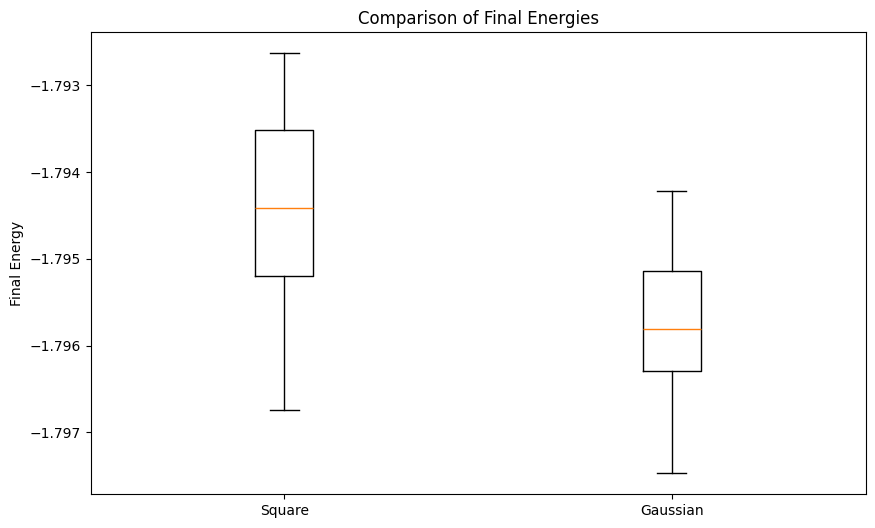

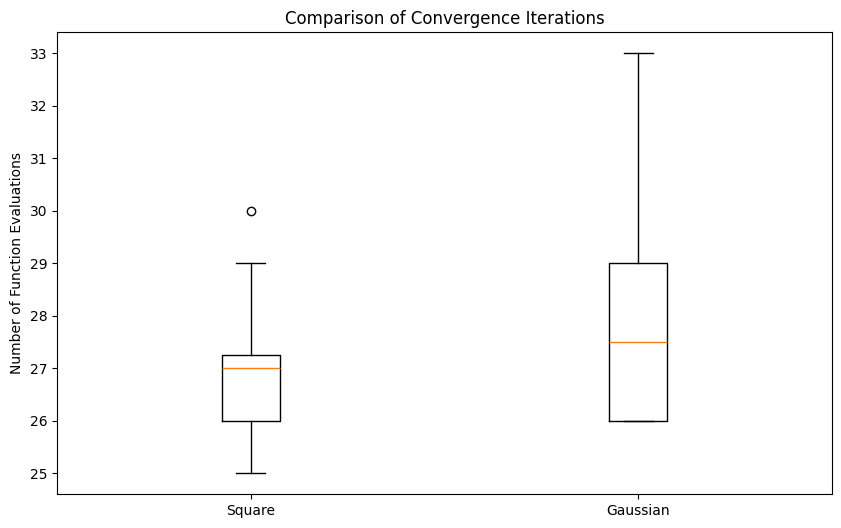

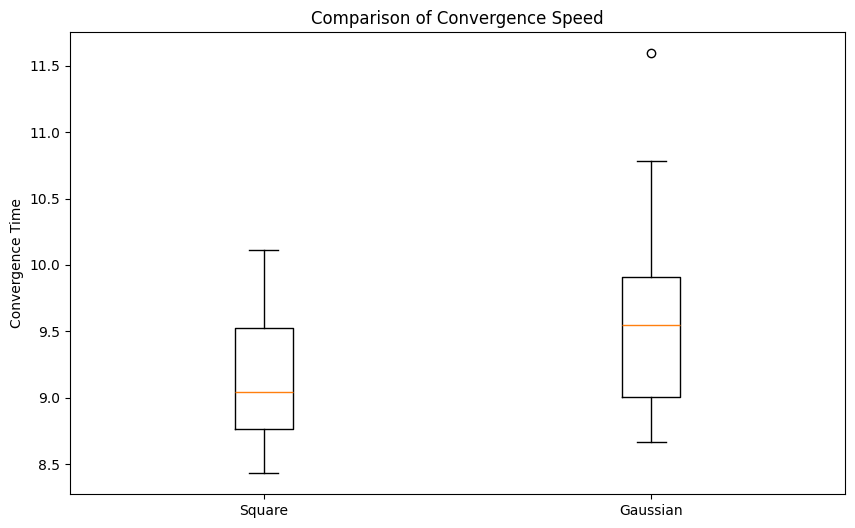

In [96]:
# Perform multiple runs
n_runs = 20
square_energies = []
gaussian_energies = []
square_nfevs = []
gaussian_nfevs = []
square_time = []
gaussian_time = []

for _ in range(n_runs):
    tic = time.perf_counter()
    result_square = minimize(square_H2_cost, 
                            square_initial, 
                            method='COBYLA', 
                            options = {'maxiter': 1000}) 
    toc = time.perf_counter()
    square_time.append(toc-tic)
    tic = time.perf_counter()
    result_gaussian = minimize(gauss_H2_cost, 
                            gauss_initial, 
                            method='COBYLA', 
                            options = {'maxiter': 1000})
    toc = time.perf_counter()
    gaussian_time.append(toc-tic)    
    square_energies.append(result_square.fun)
    gaussian_energies.append(result_gaussian.fun)
    square_nfevs.append(result_square.nfev)
    gaussian_nfevs.append(result_gaussian.nfev)

# Box plot of final energies
plt.figure(figsize=(10, 6))
plt.boxplot([square_energies, gaussian_energies], labels=['Square', 'Gaussian'])
plt.ylabel('Final Energy')
plt.title('Comparison of Final Energies')
plt.show()

# Box plot of number of function evaluations
plt.figure(figsize=(10, 6))
plt.boxplot([square_nfevs, gaussian_nfevs], labels=['Square', 'Gaussian'])
plt.ylabel('Number of Function Evaluations')
plt.title('Comparison of Convergence Iterations')
plt.show()

# Box plot of number of function evaluations
plt.figure(figsize=(10, 6))
plt.boxplot([square_time, gaussian_time], labels=['Square', 'Gaussian'])
plt.ylabel('Convergence Time')
plt.title('Comparison of Convergence Speed')
plt.show()

Gaussian pulse performed slightly better in terms of final energy

## Part 2.4: Comparison of Different Optimizers

Let's compare the performance of different optimizers, including a gradient-based and gradient_free:

Gradient-free optimizer: COBYLA
Finished the VQE in 9.7731 seconds
Optimized sigma (unscaled): 4.99998302824666
Optimized amplitude (unscaled): 5.000098549274926
Final energy: -1.796896628
Gradient-based optimizer: BFGS
Finished the VQE in 27.3320 seconds
Optimized sigma (unscaled): 5.000040562504912
Optimized amplitude (unscaled): 5.000062608014337
Final energy: -1.7962838719999998
Gradient-free optimizer: Powell
Finished the VQE in 23.7153 seconds
Optimized sigma (unscaled): 19.094487720963933
Optimized amplitude (unscaled): 0.0013440114131717529
Final energy: -1.7963675559999999
Gradient-based optimizer: CG
Finished the VQE in 25.8130 seconds
Optimized sigma (unscaled): 5.0
Optimized amplitude (unscaled): 5.0
Final energy: -1.796312908
Gradient-free optimizer: Nelder-Mead
Finished the VQE in 797.5695 seconds
Optimized sigma (unscaled): 5.0
Optimized amplitude (unscaled): 5.000000000000002
Final energy: -1.7994575399999997


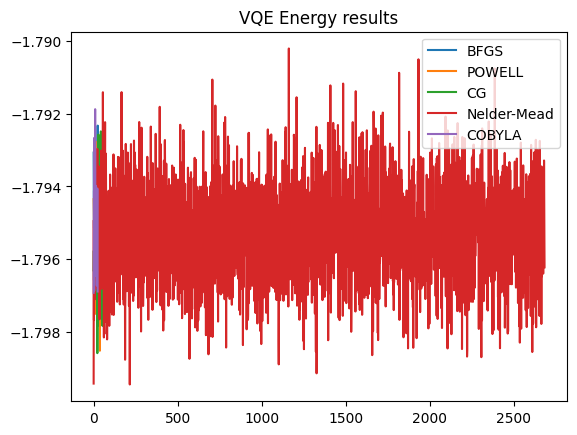

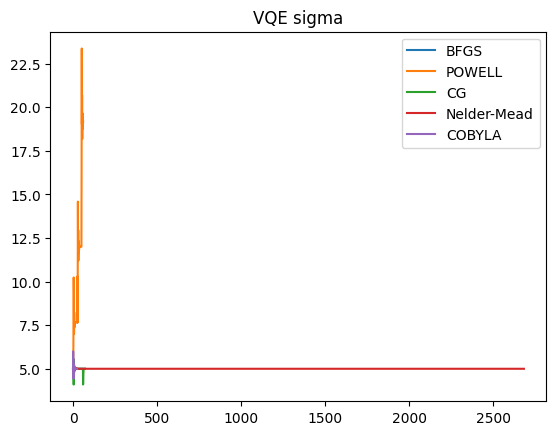

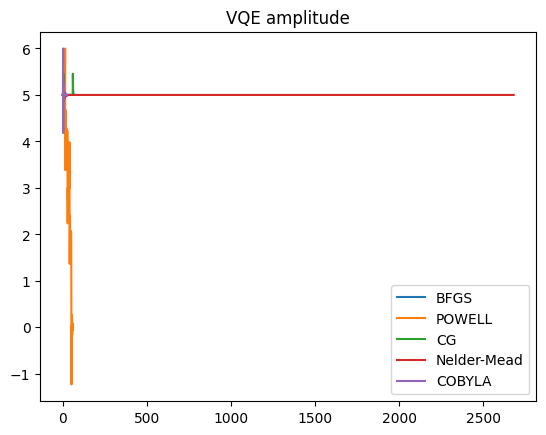

In [125]:
# Create new function for gaussian pulse that save the history
def run_vqe_gauss_save_history(optimizer):
    gs_history = []
    gs_history_theta0 = []
    gs_history_theta1 = []

    def evaluate_energy_from_gauss_save_history(theta: List[float], amp_scaling: float, sigma_scaling: float, paulis: List[str], coeffs: List[float], shots: int) -> float:
        cost = evaluate_energy_from_gauss(theta, amp_scaling, sigma_scaling, paulis, coeffs, shots)
        gs_history.append(cost)
        gs_history_theta0.append(theta[0])
        gs_history_theta1.append(theta[1])
        return cost

    gauss_H2_cost_history = lambda params: evaluate_energy_from_gauss_save_history(
        theta=params,
        amp_scaling=amp_scaling,
        sigma_scaling=sigma_scaling,
        paulis=paulis,
        coeffs=coeff_values,
        shots=shots
    )

    result = minimize(gauss_H2_cost_history, 
                    gauss_initial, 
                    method=optimizer, 
                    options = {'maxiter': 1000})
    return result, list(gs_history), list(gs_history_theta0), list(gs_history_theta1)
    
# Gradient-free optimizer: COBYLA
tic = time.perf_counter()
result, cobyla_history, cobyla_history_theta0, cobyla_history_theta1 = run_vqe_gauss_save_history("COBYLA")
toc = time.perf_counter()

print("Gradient-free optimizer: COBYLA")
print(f"Finished the VQE in {toc - tic:0.4f} seconds")

print(f"Optimized sigma (unscaled): {result.x[0]}")
print(f"Optimized amplitude (unscaled): {result.x[1]}")
print(f"Final energy: {result.fun}")

# Gradient-based optimizer: BFGS
tic = time.perf_counter()
result, bfgs_history, bfgs_history_theta0, bfgs_history_theta1 = run_vqe_gauss_save_history("BFGS")
toc = time.perf_counter()

print("Gradient-based optimizer: BFGS")
print(f"Finished the VQE in {toc - tic:0.4f} seconds")

print(f"Optimized sigma (unscaled): {result.x[0]}")
print(f"Optimized amplitude (unscaled): {result.x[1]}")
print(f"Final energy: {result.fun}")

# Gradient-free optimizer: Powell
tic = time.perf_counter()
result, powell_history, powell_history_theta0, powell_history_theta1 = run_vqe_gauss_save_history("POWELL")
toc = time.perf_counter()

print("Gradient-free optimizer: Powell")
print(f"Finished the VQE in {toc - tic:0.4f} seconds")

print(f"Optimized sigma (unscaled): {result.x[0]}")
print(f"Optimized amplitude (unscaled): {result.x[1]}")
print(f"Final energy: {result.fun}")

# Gradient-based optimizer: CG (Conjugate Gradient)
tic = time.perf_counter()
result, cg_history, cg_history_theta0, cg_history_theta1 = run_vqe_gauss_save_history("CG")
toc = time.perf_counter()

print("Gradient-based optimizer: CG")
print(f"Finished the VQE in {toc - tic:0.4f} seconds")

print(f"Optimized sigma (unscaled): {result.x[0]}")
print(f"Optimized amplitude (unscaled): {result.x[1]}")
print(f"Final energy: {result.fun}")

# Gradient-free optimizer: Nelder-Mead
tic = time.perf_counter()
result, NM_history, NM_history_theta0, NM_history_theta1 = run_vqe_gauss_save_history('Nelder-Mead')
toc = time.perf_counter()

print("Gradient-free optimizer: Nelder-Mead")
print(f"Finished the VQE in {toc - tic:0.4f} seconds")

print(f"Optimized sigma (unscaled): {result.x[0]}")
print(f"Optimized amplitude (unscaled): {result.x[1]}")
print(f"Final energy: {result.fun}")


# Plot interesting graphs
fig = plt.figure()
plt.title("VQE Energy results")
plt.plot(bfgs_history, label='BFGS')
plt.plot(powell_history, label='POWELL')
plt.plot(cg_history, label='CG')
plt.plot(NM_history, label='Nelder-Mead')
plt.plot(cobyla_history, label='COBYLA')
plt.legend()
plt.show()

fig = plt.figure()
plt.title("VQE sigma")
plt.plot(bfgs_history_theta0, label='BFGS')
plt.plot(powell_history_theta0, label='POWELL')
plt.plot(cg_history_theta0, label='CG')
plt.plot(NM_history_theta0, label='Nelder-Mead')
plt.plot(cobyla_history_theta0, label='COBYLA')

plt.legend()
plt.show()

fig = plt.figure()
plt.title("VQE amplitude")
plt.plot(bfgs_history_theta1, label='BFGS')
plt.plot(powell_history_theta1, label='POWELL')
plt.plot(cg_history_theta1, label='CG')
plt.plot(NM_history_theta1, label='Nelder-Mead')
plt.plot(cobyla_history_theta1, label='COBYLA')
plt.legend()
plt.show()

Notice the best optimizer we got considering only final energy is Nelder_Mead\
But it takes too long to converge, therefore the actual best optimizer is COBYLA very short in time and got the next best result

## Part 2.5: Comparison of Different Noise Models

To compare different noise models, we'll first need to create custom noise models:

In [126]:
def create_pauli_error(p, error_type='X'):
        return pauli_error([(error_type, p), ('I', 1 - p)])

def create_simple_noise_model(p_reset, p_meas, p_gates):
    noise = NoiseModel()
    for error_type, p in [("reset", p_reset), ("measure", p_meas)]:
        noise.add_all_qubit_quantum_error(create_pauli_error(p), error_type)
    for gate in ["u1", "u2", "u3"]:
        noise.add_all_qubit_quantum_error(create_pauli_error(p_gates), gate)
    return noise

def create_thermal_noise_model(num_qubits=1):
    T1s = np.random.normal(50e3, 10e3, num_qubits)
    T2s = np.minimum(np.random.normal(70e3, 10e3, num_qubits), 2 * T1s)
    times = {"u1": 0, "u2": 50, "u3": 100, "cx": 300, "reset": 1000, "measure": 1000}
    
    noise = NoiseModel()
    for j in range(num_qubits):
        for gate in ["reset", "measure", "u1", "u2", "u3"]:
            noise.add_quantum_error(thermal_relaxation_error(T1s[j], T2s[j], times[gate]), gate, [j])
    return noise

noise1 = create_simple_noise_model(0.05, 0.05, 0.05)
noise2 = create_thermal_noise_model()

Simple Noise Model
Finished the VQE in 6.7727 seconds
Optimized sigma (unscaled): 6.107191114815779
Optimized amplitude (unscaled): 4.504944797182965
Final energy: -1.7485816079999998
Thermal Noise Model
Finished the VQE in 5.7722 seconds
Optimized sigma (unscaled): 6.69076865294665
Optimized amplitude (unscaled): 4.276796329703311
Final energy: -1.82344364


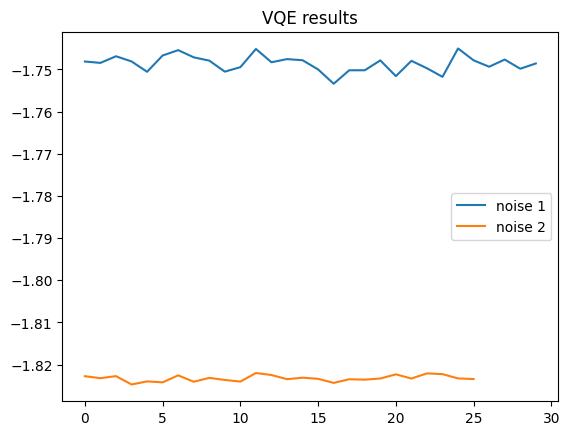

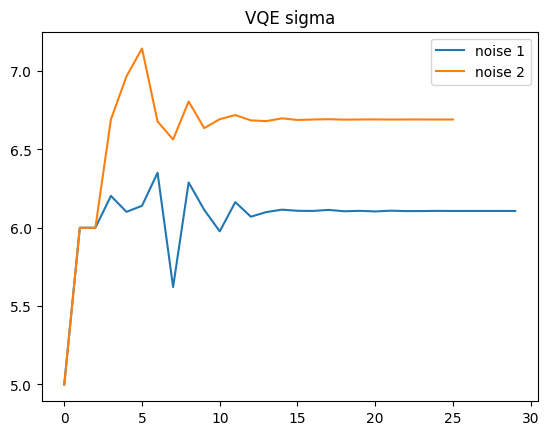

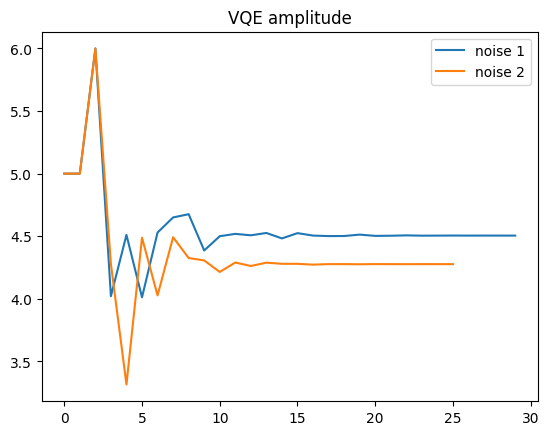

In [127]:
# run VQE on noise model 1
def run_circ_pulse(pulses: List[pulse.Schedule], shots: int) -> List[dict]:
    results = []
    for pulse_sched in pulses:
        pulse_results = backend_pulse.run(pulse_sched, shots=shots, noise_model = noise1).result()
        results.append(pulse_results.get_counts())
    return results

tic = time.perf_counter()
result, n1_history, n1_history_theta0, n1_history_theta1 = run_vqe_gauss_save_history("COBYLA")
toc = time.perf_counter()

print("Simple Noise Model")
print(f"Finished the VQE in {toc - tic:0.4f} seconds")

print(f"Optimized sigma (unscaled): {result.x[0]}")
print(f"Optimized amplitude (unscaled): {result.x[1]}")
print(f"Final energy: {result.fun}")

# run VQE on noise model 2
def run_circ_pulse(pulses: List[pulse.Schedule], shots: int) -> List[dict]:
    results = []
    for pulse_sched in pulses:
        pulse_results = backend_pulse.run(pulse_sched, shots=shots, noise_model=noise2).result()
        results.append(pulse_results.get_counts())
    return results

tic = time.perf_counter()
result, n2_history, n2_history_theta0, n2_history_theta1 = run_vqe_gauss_save_history("COBYLA")
toc = time.perf_counter()

print("Thermal Noise Model")
print(f"Finished the VQE in {toc - tic:0.4f} seconds")

print(f"Optimized sigma (unscaled): {result.x[0]}")
print(f"Optimized amplitude (unscaled): {result.x[1]}")
print(f"Final energy: {result.fun}")

fig = plt.figure()
plt.title("VQE results")
plt.plot(n1_history, label='noise 1')
plt.plot(n2_history, label='noise 2')
plt.legend()
plt.show()

fig = plt.figure()
plt.title("VQE sigma")
plt.plot(n1_history_theta0, label='noise 1')
plt.plot(n2_history_theta0, label='noise 2')
plt.legend()
plt.show()

fig = plt.figure()
plt.title("VQE amplitude")
plt.plot(n1_history_theta1, label='noise 1')
plt.plot(n2_history_theta1, label='noise 2')
plt.legend()
plt.show()

Both models converge quickly to the final result but the second noise model proformed better in terms of final energy

## Part 2.6: Transpilation and Duration Comparison

Let's compare the duration of the transpiled circuit (single Ry gate) with the optimized pulse:

In [128]:
qc = RY_ansatz([Ry_angle])

pulse_be = FakeOpenPulse2Q()
qc_tr = transpile(qc, pulse_be)
qc_tr.draw()

┌──────────────────┐
      q_0 -> 0 ┤ U3(-0.10537,0,0) ├
               └──────────────────┘
ancilla_0 -> 1 ────────────────────
                                   
          c: 1/════════════════════

In [129]:
# Optimized angle
gate = Instruction('u3', 1, 0, [[Ry_angle], 0 ,0])
sx = pulse_be.defaults().instruction_schedule_map.get(gate, 0)
s = pulse.Schedule()
s += sx
print(s.duration)

# Random angle
gate = Instruction('u3', 1, 0, [np.random.rand()*2*np.pi, np.random.rand()*2*np.pi, np.random.rand()*2*np.pi])
sx = pulse_be.defaults().instruction_schedule_map.get(gate, 0)
s = pulse.Schedule()
s += sx
print(s.duration)

# Duration of best pulse
print(int(np.abs(np.ceil(n2_history_theta0[-1]*sigma_scaling))))

4
4
335


We can see that regardless of the angle of the Ry gate, the duration is 4dt\
Also, the duration of the optimized pulse gate is much bigger than 4dt, that is becuase it is depended on the initial values of the algorithm, we can probably start with lower initial values and get the same result with better duration